# From symbols and expressions to interactive webapps

Model development follows a general work flow

**Phase I: Jupyter development phase**
1. Derive the model equations, use sympy to rapidly prototype algebraic, differential and integral formulas involved in the model
2. Transform the important expressions to executable python functions using `sp.lambdify` with `numpy` interface to evaluate derived formulas on arrays
3. Test the and demonstrate the correctness of the expressions using visualization `matplotlib` singular plots. Even better, provide an interaction interfaces using `ipywidgets`. 

**Phase II: Python packaging phase**
4. Define a class diagram reflecting the physical nature of the problem with objects (Beam, Materialmodel, Reinforcementbar).
5. Associate the executable functions derived in the Phase I with the class as methods or as properties
6. Provide an application programming interface

**Phase III: Jupyter examples/studies/webapp**
6. Import the designed Python package into the a Jupyter notebooks, explain and demonstrate the features of the package. 
7. Design a jupyter interface using `ipywidgets` showing the functionality of an implemented package in an interactive way
8. Provide one or more Jupyter notebooks as webapps on `github` that can be executed using the `binder` service. 
9. Use `zenodo` to produce a doi to enable package citations in papers. 

@TODO - installation on pypi - 
`pip install bmcs_beam`

## Sympy model definition

In [1]:
%matplotlib widget

In [2]:
import sympy as sp
sp.init_printing()

Let us construct a model calculating extreme values a quadratic function
\begin{align}
y = ax^2 + bx + c
\end{align}
This function represents our model

In [3]:
a, b, c, zeta = sp.symbols(r'a,b,c,\zeta_\mathrm{roman}')
x = sp.Symbol('x')

In [4]:
y_ = a * x**2 + b * x + c + zeta*x
y_

In [5]:
y_dx_ = y_.diff(x)
y_dx_

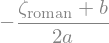

In [6]:
x_argmax_ = sp.solve(y_dx_, x)[0]
x_argmax_

In [7]:
param_names = ('a', 'b', 'c', 'zeta')
get_params = lambda param_names, **kw: tuple(kw[name] for name in param_names)
sp_params = tuple(globals()[name] for name in param_names)
sp_params

## Lambdify the symbolic functions

In `sympy` symbolic expressions be transformed to numerical functions 
using the `lambdify` method. Thus, the following code generates the 
callable functions for a specified value of the variable `x` and the 
model parameters `a,b,c,zeta`.

In [8]:
get_x_argmax = sp.lambdify((a,b,c,zeta), x_argmax_, 'numpy', dummify=True)
get_y = sp.lambdify((x,a,b,c,zeta), y_, 'numpy', dummify=True)
get_y_dx = sp.lambdify((x,a,b,c,zeta), y_dx_, 'numpy')

However, repeating the parameters for several model parameters can 
become error prone. Moreover, the parameters are usually part 
of some model entity, e.g. `MaterialModel` or `CrossSection`.
Or `ShearZone`. To standardize the transition from a symbolic
part of the model formulation to the numerical one the 
`SymbExpr` class can be use to alleviate this step.

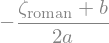

In [9]:
from bmcs_utils.api import SymbExpr, InjectSymbExpr
class QuadSymbExpr(SymbExpr):
    x = x
    a = a
    b = b
    c = c
    zeta = zeta
    x_argmax = x_argmax_
    y = y_
    y_dx = y_dx_
    
    symb_model_params = ['a','b','c','zeta']
    
    symb_expressions = [
        ('x_argmax', ()),
        ('y', ('x',)),
        ('y_dx', ('x',))
    ]

qs = QuadSymbExpr()
qs.x_argmax

## Define a model class
The basic logical unit of the application is a model class
which introduces and controls the state of the model.
Not that the `SymbExpr` class has no state - it only 
defines the mapping from inputs to outputs using symbolic expressions.

The model class defines the model parameters in form of traits (attributes)
It defines further python methods that access the injected methods.
The example below shows a class using the injection from `QuadSymbExpr`
and adds a function that returns the `y_extreme` value.

In [10]:
import traits.api as tr
from bmcs_utils.api import InjectSymbExpr

class QuadModel(InjectSymbExpr):
    # inject the `symb` object into the model
    symb_class = QuadSymbExpr

    a = tr.Float(8)
    b = tr.Float(10)
    c = tr.Float(3)
    zeta = tr.Float(4)
    
    # define new methods that make use of the symbolic injections
    def get_y_extreme(self):
        x = self.symb.get_x_argmax()
        return self.symb.get_y(x)

Note that in the calls to the injections `symb` no model parameters
need to be specified. They will be automatically fetched from the model
by the `QuadSymbExpr`. The control variable `x`, however, has to be supplied.

In [11]:
qm = QuadModel(a=4, b=8, c=2, d = -10)
qm.get_y_extreme()

## Interactive model

In [12]:
from bmcs_utils.api import \
    InteractiveModel, InteractiveWindow, View, Item

Define a model class with trait attributes representing the
model parameters. The `trait.api` package provides the basic
types `Int`, `Float`, `Str`, `Array`, `List`, `Dict`

Define `subplots` method and `update_plot` method.

In [17]:
import numpy as np

class QuadInteractiveModel(InteractiveModel, QuadModel):
    name='Quad'

    def subplots(self, fig):
        return fig.subplots(1, 2)

    def update_plot(self, axes):
        ax1, ax2 = axes
        x = np.linspace(-8,8,50)
        y = self.symb.get_y(x)
        y_dx = self.symb.get_y_dx(x)
        ax1.plot([self.symb.get_x_argmax()], [self.get_y_extreme()], 'o',
                color='red');
        ax1.fill_between(x, y, 0, alpha=0.8);
        ax2.plot(x, y_dx);
        ax2.fill_between(x, y_dx, 0, color='green', alpha=0.8);
        
    ipw_view = View(
        Item('a',minmax=(-10,10), latex='a'),
        Item('b',minmax=(-10,10), latex='b'),
        Item('c',minmax=(-10,10), latex='c'),
        Item('zeta',minmax=(-10,10), latex='zeta'),
    )

In [18]:
qim = InteractiveWindow(QuadInteractiveModel())
qim.interact()

In [15]:
class LinInteractiveModel(InteractiveModel):
    name='Lin'

    a = tr.Float(3)
    b = tr.Float(3)

    ipw_view = View(
        Item('a', param=True, latex='a', minmax=(-8,8)),
        Item('b', param=True, latex='b', minmax=(-8,8))
    )

    def subplots(self, fig):
        return fig.subplots(1)

    def update_plot(self, ax):
        x_arr = np.linspace(-8,8,50)
        y_arr = self.a * x_arr + self.b
        ax.fill_between(x_arr, y_arr,0,alpha=0.8);

In [16]:
qei = InteractiveWindow([
    QuadInteractiveModel(name='First quad',a=2),
    QuadInteractiveModel(name='Another quad'),
    LinInteractiveModel(name='Lin')],
    figsize=(8,3))
qei.interact()